In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

### Import Libraries

In [2]:
#Torch Libs
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR, OneCycleLR

#Utility and Plot Libs
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import Image


### Pytorch Version check

In [3]:
torch.__version__

'1.6.0'

### Data Transformation

In [4]:
#Need to create a data Trandform function here. there transform objects will be use fulll to apply on data

In [5]:
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])


test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

### Creating the Trainning and Testing data  

In [6]:
#Here applying the transform function we hafve created.
#What is target_transform , Need to understand

train = datasets.MNIST('./', train = True,  transform = train_transforms,  target_transform = None,  download = True)
test  = datasets.MNIST('./', train = False,  transform = test_transforms,   target_transform = None,  download = True)


In [7]:
type(train)
type(test)

torchvision.datasets.mnist.MNIST

torchvision.datasets.mnist.MNIST

### Creating Data Loader

#### Cuda Checker

In [8]:
cuda = torch.cuda.is_available()
print ('Is Cuda Available ?',cuda)

Is Cuda Available ? True


In [9]:
SEED = 1

if cuda:
    torch.cuda.manual_seed(SEED)
else:
    torch.manual_seed(SEED)

#### Based on the cuda availability we are defining the things

In [10]:
dataloader_args = dict(shuffle = True,batch_size = 128,num_workers = 4, pin_memory = True) if cuda else dict(shuffle = True,batch_size = 64)

In [11]:
dataloader_args

{'shuffle': True, 'batch_size': 128, 'num_workers': 4, 'pin_memory': True}

In [12]:
train_loader = torch.utils.data.DataLoader(train,**dataloader_args)
test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

In [13]:
pwd

'/home/jd/Desktop/EVA5/secession6'

### Extracting Statistics

In [14]:
dataiter = iter(train_loader)
images,label = dataiter.next()

In [15]:
print(images.shape)
print(label.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


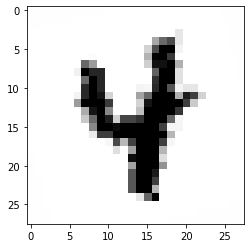

In [16]:
plt.imshow(images[0].numpy().squeeze(),cmap = 'gray_r')

### Plotting all the image

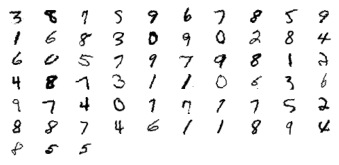

In [17]:
figure = plt.figure()
num_of_images = 63
for index in range(1, num_of_images + 1):
    _= plt.subplot(10, 10, index)
    _= plt.axis('off')
    _= plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model Architecture

## GBN

In [18]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)



In [19]:

class Net(nn.Module):
    def __init__(self,ghost = False):
        super(Net, self).__init__()
        self.dropout_value = 0.05
        # Input Block
        print('GHOST BHAI is ',ghost)
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=4, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=4, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU(),
        ) # input_size = 26 output_size = 24 receptive_field = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 24 output_size = 22 receptive_field = 7       
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 22 output_size = 20 receptive_field = 9        
        
        
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 20 output_size = 10 receptive_field = 18

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10) if ghost is False else GhostBatchNorm(10, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 10 output_size = 8 receptive_field = 20
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if ghost is False else GhostBatchNorm(16, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 8 output_size = 6 receptive_field = 22
        
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16) if ghost is False else GhostBatchNorm(16, num_splits=64//32, weight=False),
            nn.Dropout(self.dropout_value),
            nn.ReLU()
        ) # input_size = 6 output_size = 4 receptive_field = 24
        
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 
        
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 1 output_size = 1  receptive_field = 24
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool1(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)  
        x = self.convblock8(x)
        x = x.view(-1, 10)
        
        return F.log_softmax(x, dim=-1)

### Model Param

In [20]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
GHOST BHAI is  False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
           Dropout-7           [-1, 10, 24, 24]               0
              ReLU-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 10, 22, 22]             900
      BatchNorm2d-10           [-1, 10, 22, 22]              20
          Dropout-11           [-1, 10, 22, 22]               0
             ReLU-12           [-1, 10, 22, 22]               0
           Conv2d-13           [-1, 10, 20, 20]             900
      BatchNo

In [21]:
#L1 Loss Calculator
def L1_Loss_calc(model, factor=0.0005):
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        #zero_vector = torch.rand_like(param)*0
        zero_vector = torch.zeros_like(param)
        reg_loss += l1_crit(param,zero_vector)
    return factor * reg_loss

In [22]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch,scheduler,l1_check =False):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        #adding L1 loss function call 

        if( l1_check == True ):
            regloss = L1_Loss_calc(model, 0.0005)
            regloss /= len(data) # by batch size
            loss += regloss

        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

#         pbar.set_description(desc= f'Loss={loss.item():0.6f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        pbar.set_description(desc= f'Loss={train_loss/(batch_idx+1):0.6f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_loss /= len(train_loader)
    
    acc = np.round(100. * correct/len(train_loader.dataset),2) #processed # 
    scheduler.step()
    
    return acc, np.round(train_loss,5)

In [23]:
def test(model, device, test_loader,l1_check = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    if( l1_check == True ):
            regloss = L1_Loss_calc(model, 0.0005)
            regloss /= len(data) # by batch size
            test_loss += regloss

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100 * correct / len(test_loader.dataset)))
    acc = 100 * correct /len(test_loader.dataset)
    acc = np.round(acc,2)
    
    return acc, test_loss
    

### Temp Store

### Lets add L2 

In [24]:
len(train_loader)

469

In [25]:
def model_building(typ, model, device,train_loader, test_loader,l1_check = False, l2_val = 0, EPOCHS = 3,learning_rate = 0.01):
    
    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []
    
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=EPOCHS)
    
    print ('Model with ', typ)
    for epoch in range(1,EPOCHS):
        print("EPOCH:", epoch)
        acc,loss =  train(model, device, train_loader, optimizer, epoch,scheduler,l1_check= True)
        train_acc.append(acc)
        train_losses.append(loss)
        
        acc,loss =  test(model, device, test_loader,l1_check= True)
        test_acc.append(acc)
        test_losses.append(loss)
        
    return train_acc,train_losses,test_acc,test_losses

## Missclassifications


In [26]:
def miss_classification(typ, model, device, testloader, num_of_images = 25, filename='missclass'):
    model.eval()
    misclassified_cnt = 0
    fig = plt.figure(figsize=(12,12))
    print ('Missclassification on ', typ)
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        pred_marker = pred.eq(target.view_as(pred))   
        wrong_idx = (pred_marker == False).nonzero()
        for idx in wrong_idx:
            index = idx[0].item()
            title = "Actul:{}, Pred:{}".format(target[index].item(), pred[index][0].item())
            ax = fig.add_subplot(5, 5, misclassified_cnt+1, xticks=[], yticks=[]) 
            ax.set_title(title)
            plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
            misclassified_cnt += 1
            if(misclassified_cnt==num_of_images):
                break
        if(misclassified_cnt==num_of_images):
            break
    
    fig.savefig(typ + '_missclassified_images'+ '.jpg') 
    return

In [27]:
def plot_acc_loss(typ, train_acc,train_losses,test_acc,test_losses):
    fig, axs = plt.subplots(1,2,figsize = (20,5))
    print ('Accuracy model on  ', typ)
    plt.autoscale()
    axs[0].plot(train_acc,color = 'red')
    axs[0].plot(test_acc,color = 'green')
    title = 'Training/testing accuracy'
    axs[0].set_title(title)
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train acc','test acc'], loc='best')
#     fig.set_figheight(10)
#     fig.set_figwidth(20)
       
    axs[1].plot(train_losses,color = 'red')
    axs[1].plot(test_losses,color = 'green')
    title = 'Training/Testing Loss'
    axs[1].set_title(title)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train loss','test loss'], loc='best')
    plt.title(typ + 'model Accuracy Vs Loss')
#     fig.set_figheight(10)
#     fig.set_figwidth(20)

    plt.show()

In [28]:
def plot_all(train_acc1=[0,0] ,train_losses1=[0,0] ,test_acc1 =[0,0],test_losses1=[0,0],train_acc2=[0,0] ,train_losses2=[0,0] ,test_acc2=[0,0] ,test_losses2=[0,0],train_acc3=[0,0] ,train_losses3=[0,0] ,test_acc3 =[0,0],test_losses3=[0,0],train_acc4=[0,0] ,train_losses4 =[0,0],test_acc4=[0,0] ,test_losses4=[0,0],train_acc5 =[0,0],train_losses5 =[0,0],test_acc5=[0,0] ,test_losses5=[0,0]):
    fig,ax = plt.subplots(1,2,figsize=(30,7))
    
    # ploting the Accuracy 
    
    ax[0].plot(train_acc1)
    ax[0].plot(train_acc2)
    ax[0].plot(train_acc3)
    ax[0].plot(train_acc4)
    ax[0].plot(train_acc5)
    ax[0].set_title('Model Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epochs')
    ax[0].legend(['L1+BN_acc','L2+BN_acc','L1 & L2 + BN_acc','GBN_acc','L1 & L2 + GBN_acc'], loc='best')
    #Ploting the losses 
    
    ax[1].plot(train_losses1)
    ax[1].plot(train_losses2)
    ax[1].plot(train_losses3)
    ax[1].plot(train_losses4)
    ax[1].plot(train_losses5)
    ax[1].set_title('Model Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epochs')
    ax[1].legend(['L1+BN_loss','L2+BN _loss','L1 & L2 + BN_loss','GBN_loss','L1 & L2 + GBN_loss'], loc='best')
    
    plt.show()
    fig.savefig('Comparision.')

In [29]:
def modelcalling(models,EPOCHS,learning_rate ):
    print ('The Number of Epochs are :', EPOCHS)
    for typ in models:
        if typ == 'L1+BN':
            
            l1_check = True
            l2_val = 0
            ghost = False
            
            model =  Net(ghost).to(device)
            train_acc1 ,train_losses1 ,test_acc1 ,test_losses1 = model_building(typ, model, device,train_loader, test_loader,l1_check ,l2_val,EPOCHS,learning_rate)
            plot_acc_loss(typ, train_acc1 ,train_losses1 ,test_acc1 ,test_losses1)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc1,'test_acc':test_acc1,'train_losses':train_losses1,'test_losses':test_losses1}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + '_missclassified_images'+ '.png')


        elif typ == 'L2+BN':
            
            l1_check = False
            l2_val = 0.03
            ghost = False
            
            model =  Net(ghost).to(device)
            train_acc2 ,train_losses2 ,test_acc2 ,test_losses2 = model_building(typ, model, device,train_loader, test_loader,l1_check,l2_val,EPOCHS,learning_rate)
            plot_acc_loss(typ, train_acc2 ,train_losses2 ,test_acc2 ,test_losses2)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc2,'test_acc':test_acc2,'train_losses':train_losses2,'test_losses':test_losses2}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

            
        elif typ == 'L1 & L2 + BN':
            
            l1_check = True
            l2_val = 0.03
            ghost = False
            
            model =  Net(ghost).to(device)
            train_acc3 ,train_losses3 ,test_acc3 ,test_losses3 = model_building(typ, model, device,train_loader, test_loader,l1_check,l2_val,EPOCHS ,learning_rate)
            plot_acc_loss(typ, train_acc3 ,train_losses3 ,test_acc3 ,test_losses3)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc3,'test_acc':test_acc3,'train_losses':train_losses3,'test_losses':test_losses3}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

            
        elif typ == 'GBN':
            
            l1_check = False
            l2_val = 0
            ghost = True
            
            model =  Net(ghost).to(device)
            train_acc4 ,train_losses4 ,test_acc4 ,test_losses4 = model_building(typ, model, device,train_loader, test_loader,l1_check,l2_val,EPOCHS,learning_rate)
            plot_acc_loss(typ, train_acc4 ,train_losses4 ,test_acc4 ,test_losses4)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc4,'test_acc':test_acc4,'train_losses':train_losses4,'test_losses':test_losses4}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

            
        elif typ == 'L1 & L2 + GBN':
            
            l1_check = True
            l2_val = 0.03
            ghost = True
            
            model =  Net(ghost).to(device)
            train_acc5 ,train_losses5 ,test_acc5 ,test_losses5 = model_building(typ, model, device,train_loader, test_loader,l1_check , l2_val , EPOCHS ,learning_rate)
            plot_acc_loss(typ, train_acc5 ,train_losses5 ,test_acc5 ,test_losses5)
            miss_classification(typ, model, device, testloader = test_loader, num_of_images = 25, filename=typ)
#             Image(filename= typ + '_missclassified_images'+ '.png' )
            
#             modelparams = {'train_acc':train_acc5,'test_acc':test_acc5,'train_losses':train_losses5,'test_losses':test_losses5}
#             file = pd.DataFrame(modelparams)
#             file.to_csv(typ + 'param'+'.csv')

        
    plot_all(train_acc1 ,train_losses1 ,test_acc1 ,test_losses1,train_acc2 ,train_losses2 ,test_acc2 ,test_losses2,train_acc3 ,train_losses3 ,test_acc3 ,test_losses3,train_acc4 ,train_losses4 ,test_acc4 ,test_losses4,train_acc5 ,train_losses5 ,test_acc5 ,test_losses5)
    
    for i in models:
        name = i + '_missclassified_images.jpg'
        print (name)
        image = io.imread(name)
        plt.subplots(figsize = (20,20))
        plt.imshow(image)
        plt.title(i + '_missclassified_images') 

  0%|          | 0/469 [00:00<?, ?it/s]

The Number of Epochs are : 25
GHOST BHAI is  False
Model with  L1+BN
EPOCH: 1


/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1262, Accuracy: 9753/10000 (97.53%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9889/10000 (98.89%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0531, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0505, Accuracy: 9900/10000 (99.00%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9921/10000 (99.21%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9920/10000 (99.20%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0462, Accuracy: 9912/10000 (99.12%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9924/10000 (99.24%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9918/10000 (99.18%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0455, Accuracy: 9921/10000 (99.21%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9937/10000 (99.37%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.040097 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:10<00:00, 43.26it/s]



Test set: Average loss: 0.0427, Accuracy: 9931/10000 (99.31%)

Accuracy model on   L1+BN


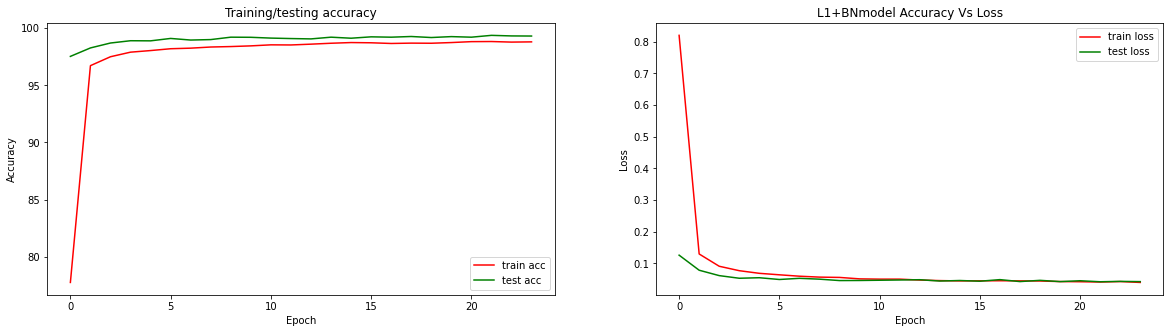

Missclassification on  L1+BN


<ipython-input-26-b67ca1ae80c8>:11: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  wrong_idx = (pred_marker == False).nonzero()
  0%|          | 0/469 [00:00<?, ?it/s]

GHOST BHAI is  False
Model with  L2+BN
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1736, Accuracy: 9600/10000 (96.00%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0755, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9876/10000 (98.76%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0575, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9904/10000 (99.04%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Accuracy: 9928/10000 (99.28%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0425, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9941/10000 (99.41%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0413, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9929/10000 (99.29%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


Loss=0.039050 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:11<00:00, 40.82it/s]



Test set: Average loss: 0.0407, Accuracy: 9940/10000 (99.40%)

Accuracy model on   L2+BN


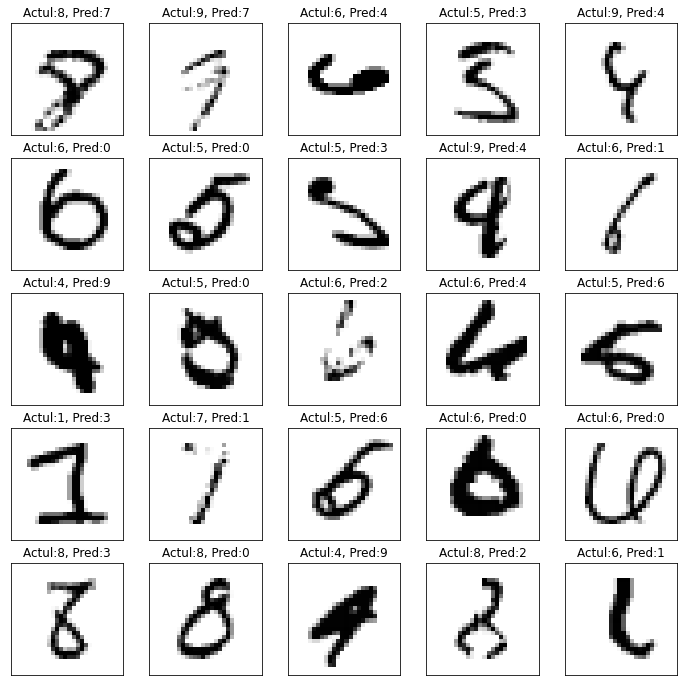

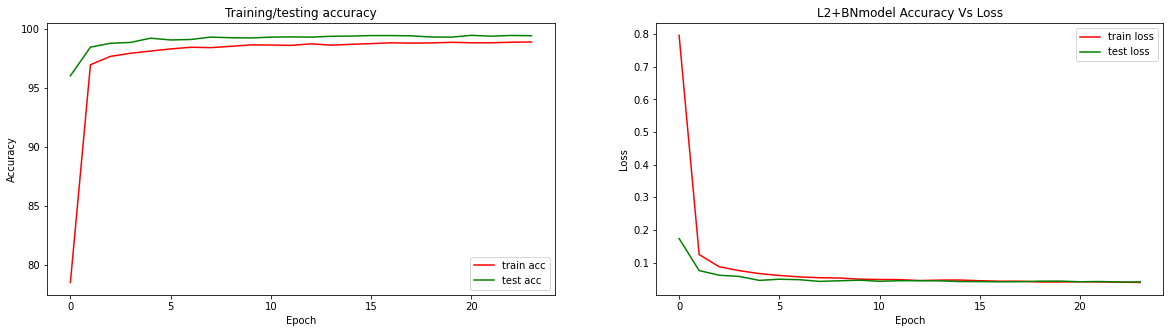

Missclassification on  L2+BN


  0%|          | 0/469 [00:00<?, ?it/s]

GHOST BHAI is  False
Model with  L1 & L2 + BN
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1984, Accuracy: 9469/10000 (94.69%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0760, Accuracy: 9840/10000 (98.40%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9877/10000 (98.77%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0544, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0533, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9923/10000 (99.23%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9922/10000 (99.22%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0445, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9915/10000 (99.15%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9927/10000 (99.27%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9925/10000 (99.25%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9933/10000 (99.33%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9942/10000 (99.42%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9945/10000 (99.45%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9932/10000 (99.32%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0433, Accuracy: 9940/10000 (99.40%)

EPOCH: 24


Loss=0.039777 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 39.06it/s]



Test set: Average loss: 0.0507, Accuracy: 9917/10000 (99.17%)

Accuracy model on   L1 & L2 + BN


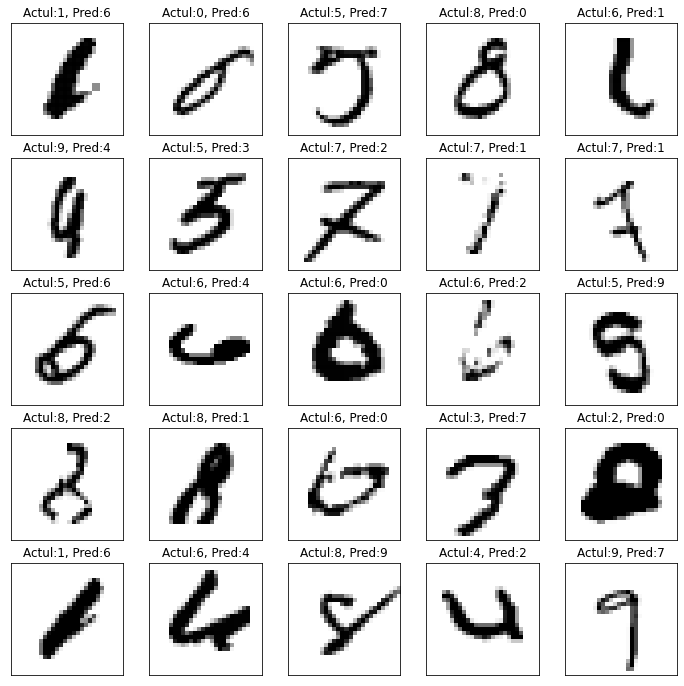

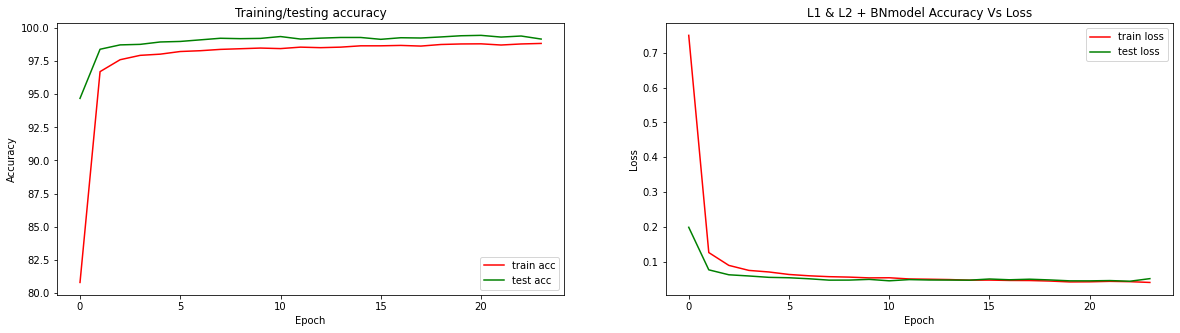

Missclassification on  L1 & L2 + BN


  0%|          | 0/469 [00:00<?, ?it/s]

GHOST BHAI is  True
Model with  GBN
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1985, Accuracy: 9712/10000 (97.12%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0997, Accuracy: 9805/10000 (98.05%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0774, Accuracy: 9860/10000 (98.60%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0705, Accuracy: 9864/10000 (98.64%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9899/10000 (98.99%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0621, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0548, Accuracy: 9905/10000 (99.05%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9904/10000 (99.04%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0527, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0500, Accuracy: 9918/10000 (99.18%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0503, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0468, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0475, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0479, Accuracy: 9921/10000 (99.21%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0450, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9930/10000 (99.30%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0440, Accuracy: 9940/10000 (99.40%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9932/10000 (99.32%)

EPOCH: 24


Loss=0.045933 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:10<00:00, 42.75it/s]



Test set: Average loss: 0.0452, Accuracy: 9934/10000 (99.34%)

Accuracy model on   GBN


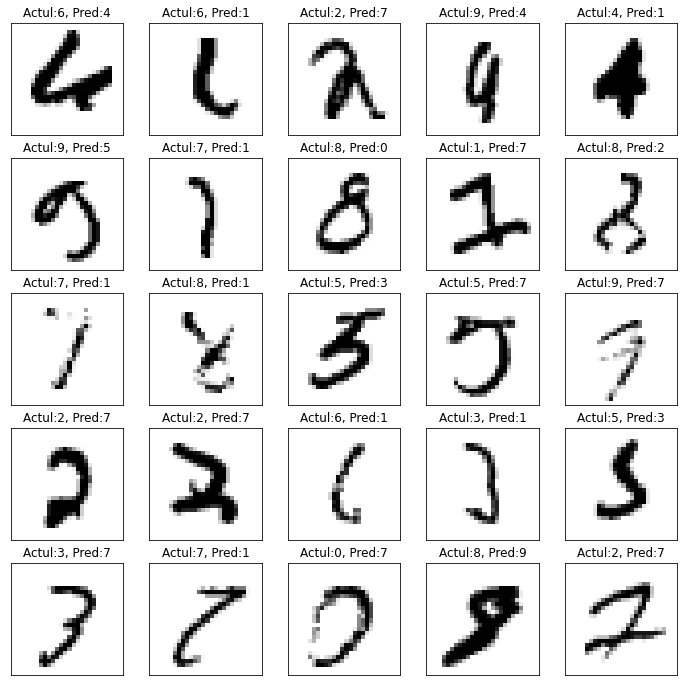

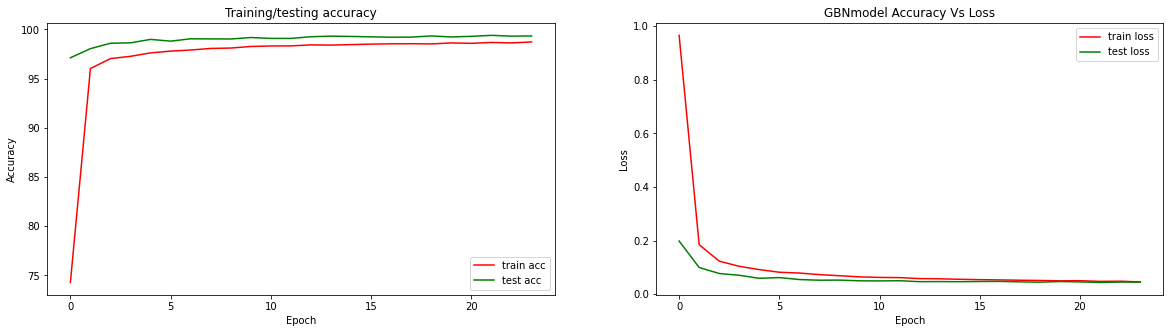

Missclassification on  GBN


  0%|          | 0/469 [00:00<?, ?it/s]

GHOST BHAI is  True
Model with  L1 & L2 + GBN
EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1860, Accuracy: 9693/10000 (96.93%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0872, Accuracy: 9827/10000 (98.27%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0814, Accuracy: 9848/10000 (98.48%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0635, Accuracy: 9875/10000 (98.75%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0573, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0530, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0526, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0553, Accuracy: 9901/10000 (99.01%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9921/10000 (99.21%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0495, Accuracy: 9916/10000 (99.16%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9922/10000 (99.22%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9921/10000 (99.21%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9929/10000 (99.29%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9914/10000 (99.14%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0486, Accuracy: 9921/10000 (99.21%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0452, Accuracy: 9931/10000 (99.31%)

EPOCH: 24


Loss=0.045797 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:10<00:00, 42.86it/s]



Test set: Average loss: 0.0466, Accuracy: 9930/10000 (99.30%)

Accuracy model on   L1 & L2 + GBN


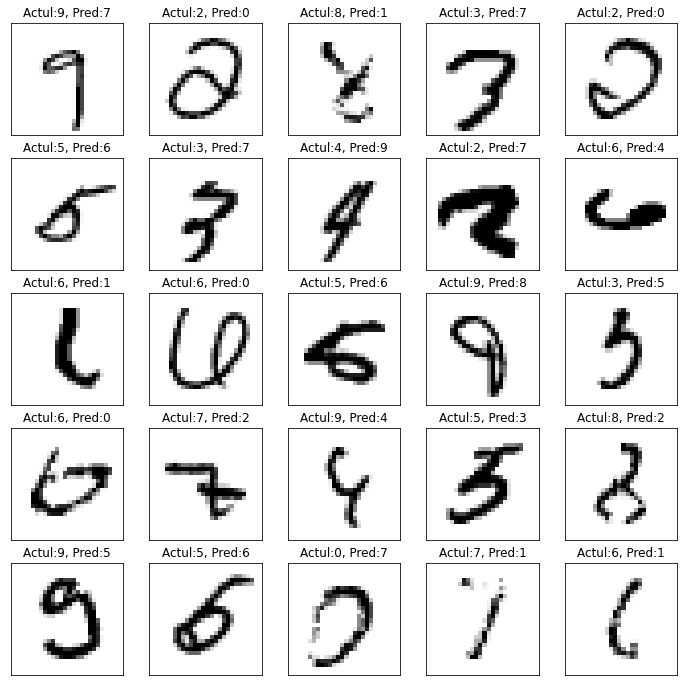

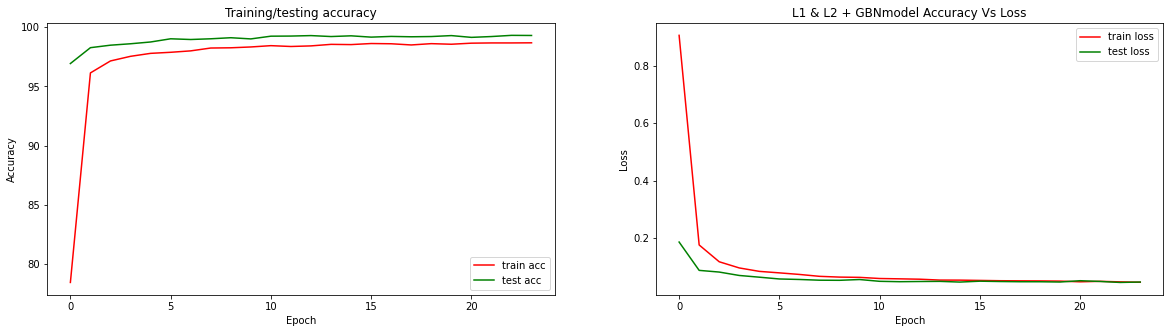

Missclassification on  L1 & L2 + GBN


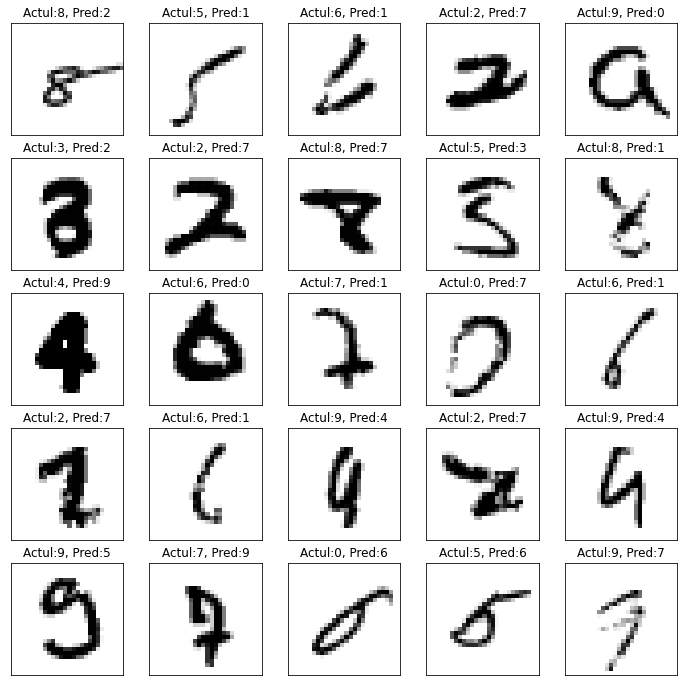

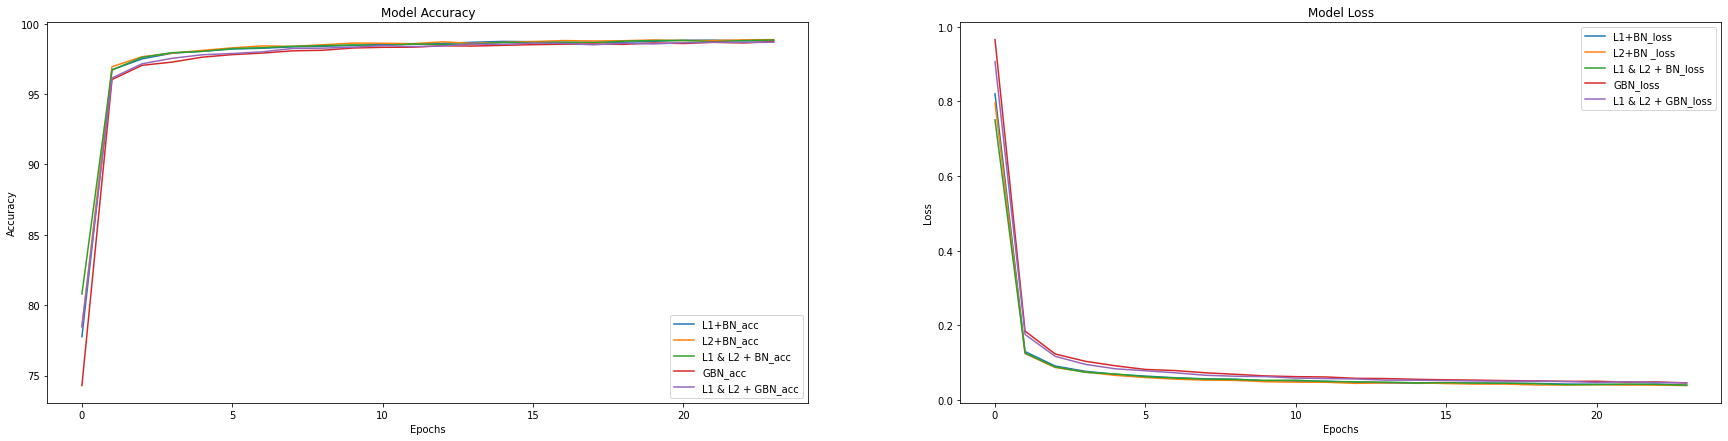

L1+BN_missclassified_images.jpg
L2+BN_missclassified_images.jpg
L1 & L2 + BN_missclassified_images.jpg
GBN_missclassified_images.jpg
L1 & L2 + GBN_missclassified_images.jpg


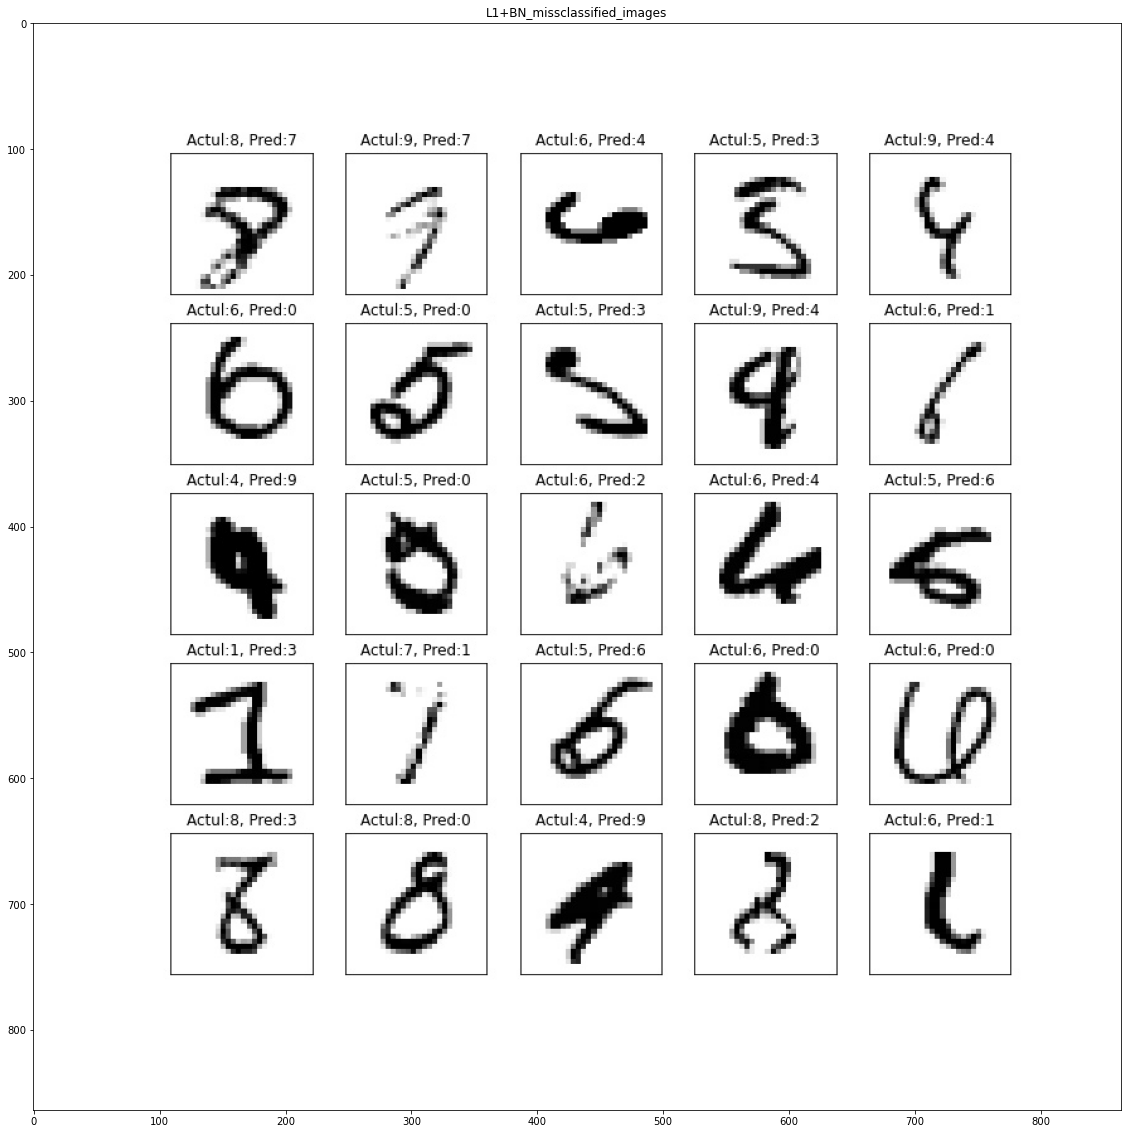

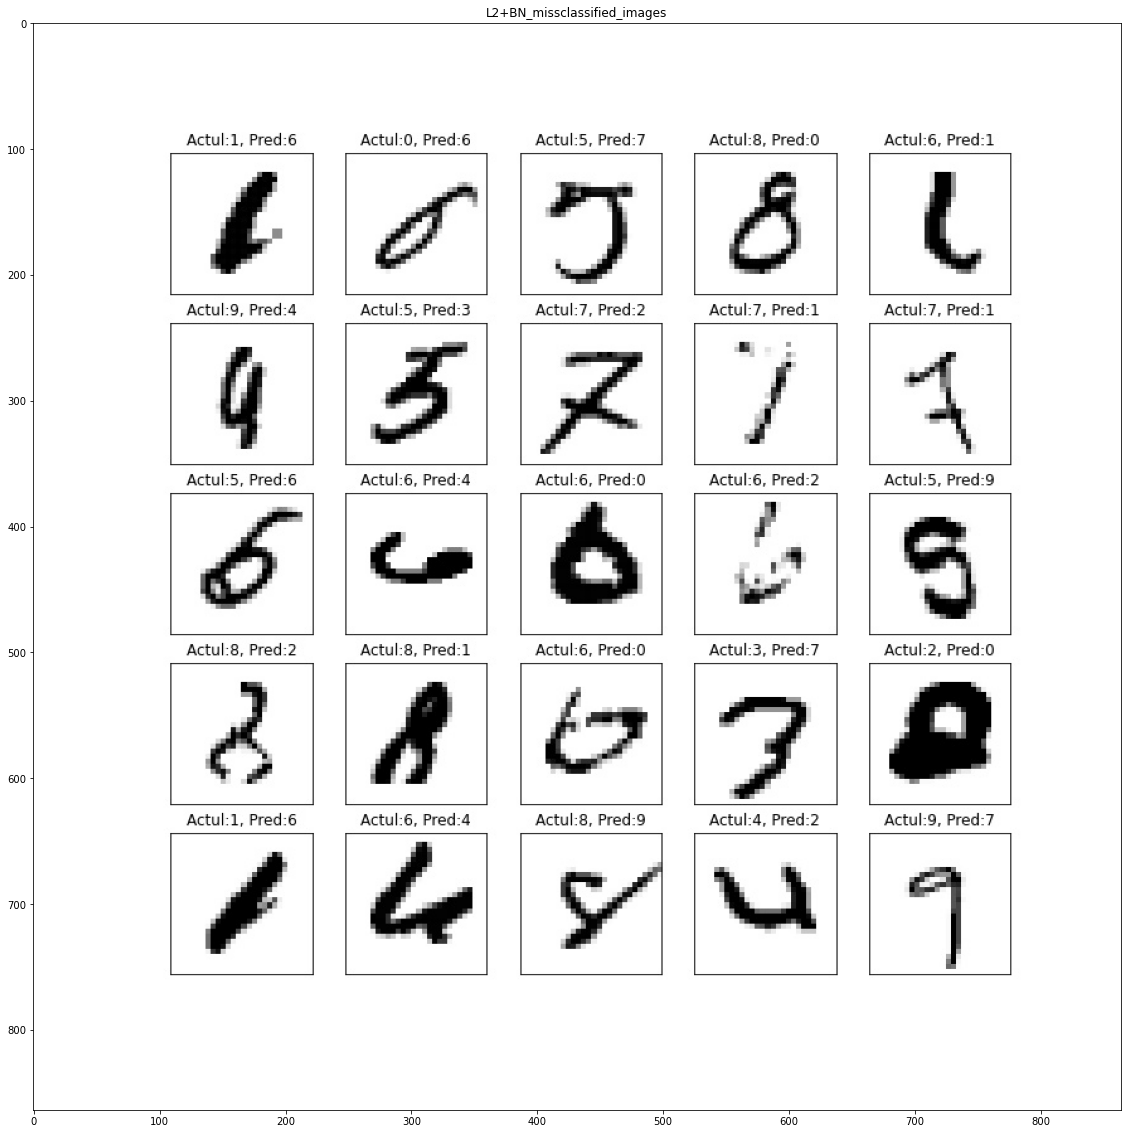

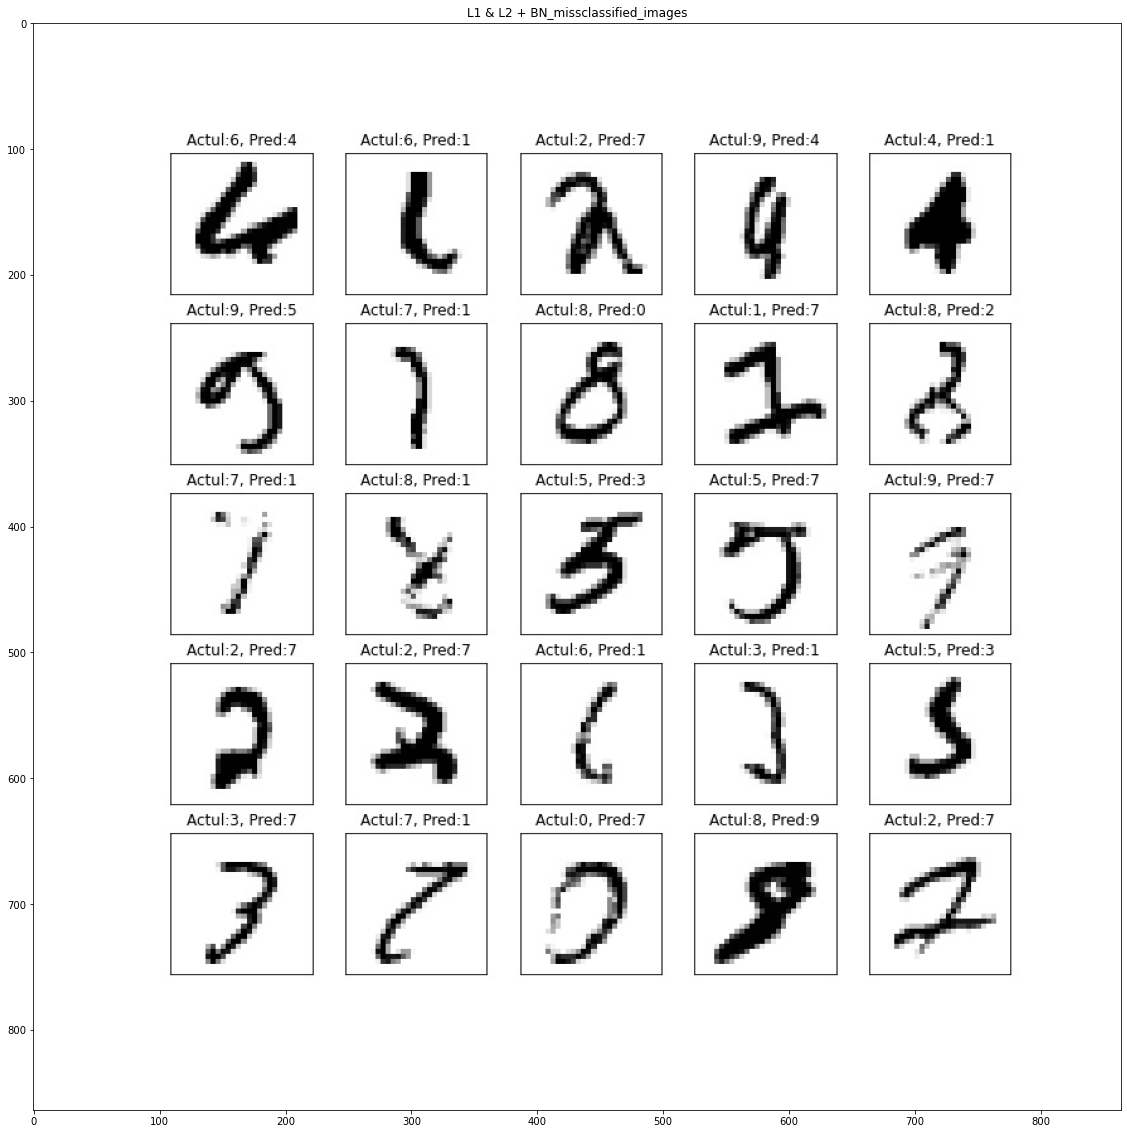

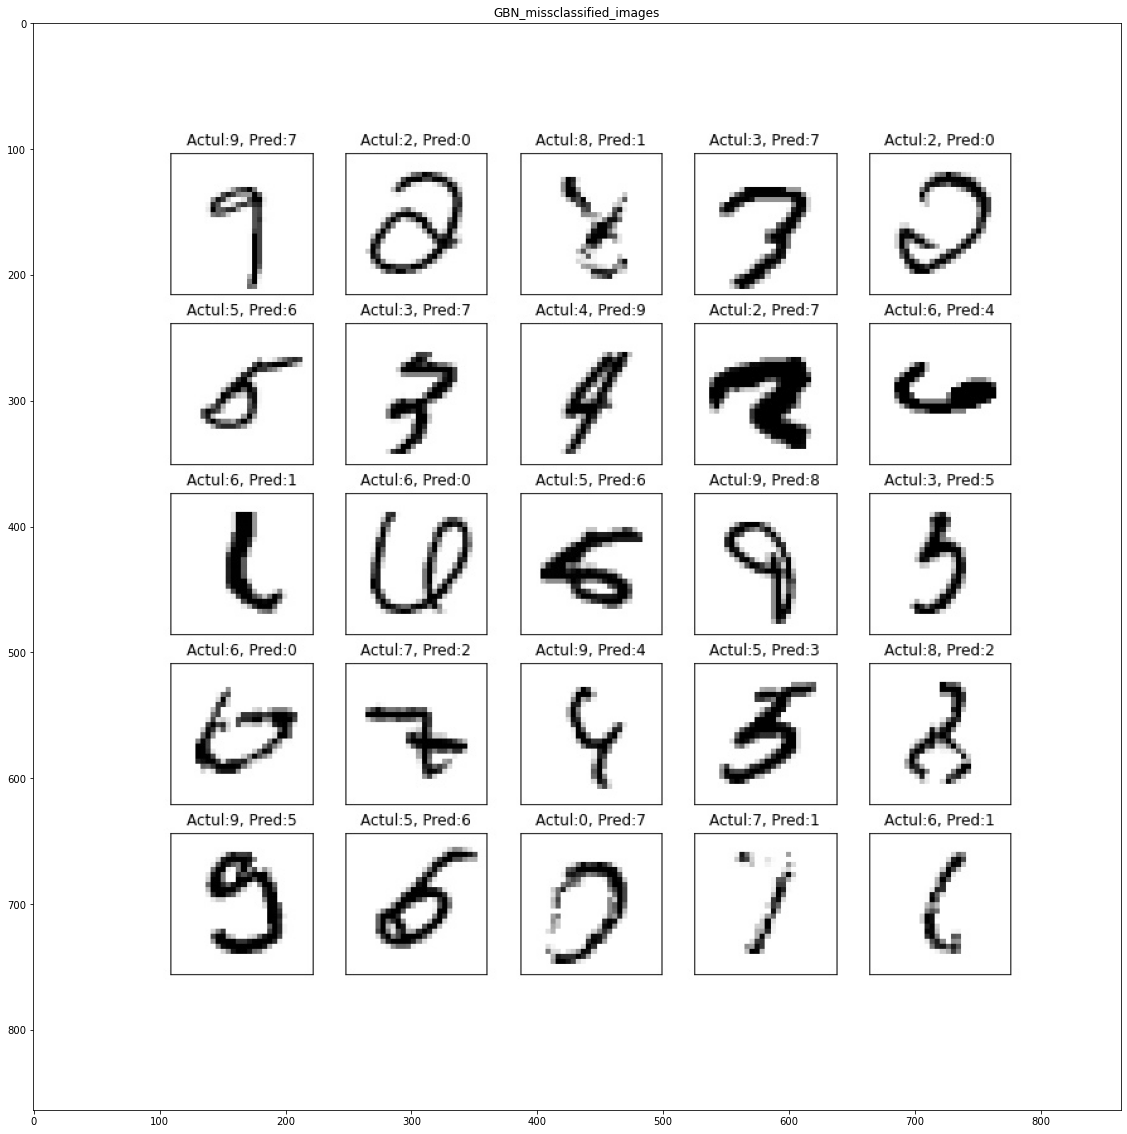

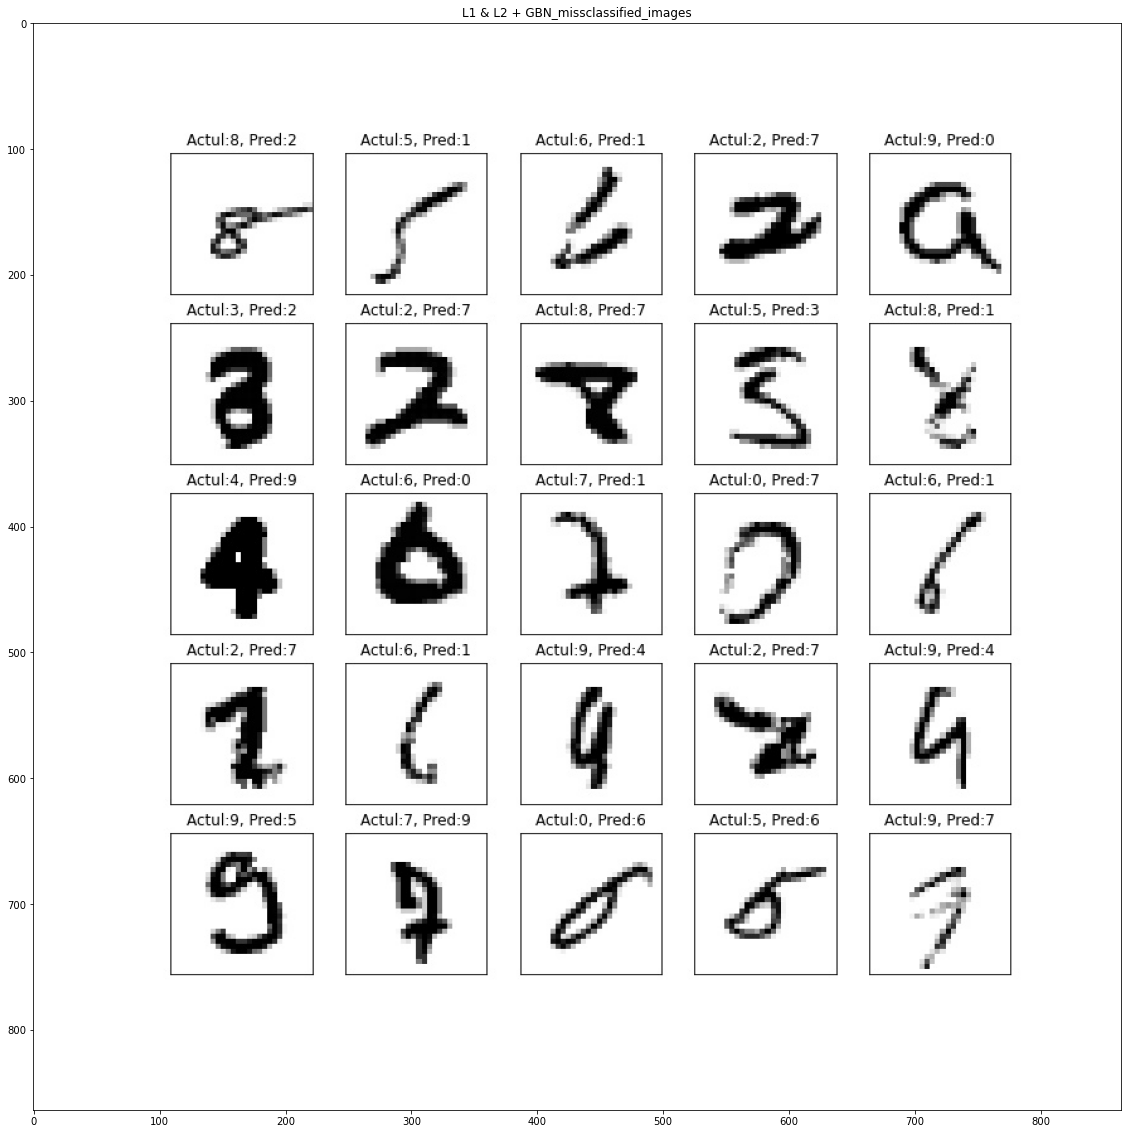

In [30]:
models = ['L1+BN','L2+BN','L1 & L2 + BN','GBN','L1 & L2 + GBN']
modelcalling(models,EPOCHS= 25,learning_rate = 0.01)

### Testing  